[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/paper/11_interpretation_gradshap_corr.ipynb)

# 6.2. GradientShap values correlation

> Visualizing the (Pearson) correlation betwee GradientShap values aggregated by Soil Taxonomy Orders

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

In [ ]:
# Python utils
from pathlib import Path
import pickle

# mirzai utilities
from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import log_transform_y
from mirzai.vis.core import (centimeter, PRIMARY_COLOR, 
                             set_style, DEFAULT_STYLE)

from fastcore.transform import compose

# Data science stack
import numpy as np

# Data vis.
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

## Load and transform

In [ ]:
src_dir = 'data'
fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)

data = X, y, X_id, depth_order

transforms = [select_y, select_tax_order, select_X, log_transform_y]
X, y, X_id, depth_order = compose(*transforms)(data)

## Setup

The required GradShap values are computed (then saved) as shown in [GradientShap values notebook](21_paper.interpretation.gradshap.html). Here we will simply load them.

In [ ]:
src_dir = Path('dumps/cnn/shaps')
shap_by_orders, _  = pickle.load(open(src_dir/'shap_by_orders_02_09_2022.pickle', "rb"))

We compute the [Pearson correlation coefficient](https://www.wikiwand.com/en/Pearson_correlation_coefficient) between the average GradientShap values of Soil Taxonomy Orders.

In [ ]:
shap_by_orders

[OrderedDict([('shap',
               array([ 1.8393685e-06, -3.4975756e-07,  1.0674637e-07, ...,
                       0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)),
              ('order', 'alfisols')]),
 OrderedDict([('shap',
               array([-5.8400028e-06, -1.0966338e-05, -1.0213902e-06, ...,
                       0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)),
              ('order', 'all')]),
 OrderedDict([('shap',
               array([ 2.3224013e-05,  1.5094614e-04, -2.2070333e-05, ...,
                       0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)),
              ('order', 'andisols')]),
 OrderedDict([('shap',
               array([2.0230336e-05, 9.7760840e-06, 9.9760737e-06, ..., 0.0000000e+00,
                      0.0000000e+00, 0.0000000e+00], dtype=float32)),
              ('order', 'aridisols')]),
 OrderedDict([('shap',
               array([-7.0780785e-05, -1.4203938e-04,  1.2610339e-05, ...,
            

In [ ]:
tax_order_sorted = ['all', 'undefined', 'mollisols', 'alfisols', 'inceptisols', 'ultisols', 
                    'entisols', 'aridisols', 'andisols','vertisols', 'histosols',
                    'spodosols', 'gelisols', 'oxisols']

In [ ]:
shap_by_orders_sorted = []
for tax in tax_order_sorted:
    shap_by_orders_sorted.append(list(filter(lambda x: x['order'] == tax, shap_by_orders))[0])

In [ ]:
# Correlation
shaps_corr = np.corrcoef(np.array([s['shap'] for s in shap_by_orders_sorted]))
corr_labels = [s['order'].capitalize() for s in shap_by_orders_sorted]

## Plot

In [ ]:
def plot_shaps_corr(shaps, labels, figsize=(6*centimeter, 6*centimeter), dpi=600):

    # Styles
    p = plt.rcParams
    p["axes.spines.bottom"] = False
    p["axes.grid"] = False
    p["xtick.major.size"] = 3
    p["xtick.major.width"] = 0.5  
    p["xtick.minor.size"] = 1
    p["xtick.minor.width"] = 0.25
    p["xtick.minor.visible"] = False
    p["xtick.labelsize"] = 4
    p["ytick.labelsize"] = 4
    p["ytick.labelleft"] = True
    p["ytick.direction"] = "out"
    p["ytick.major.size"] = 3
    p["ytick.major.width"] = 0.5
    p["ytick.minor.size"] = 1
    p["ytick.minor.width"] = 0.25
    p["ytick.minor.visible"] = False
    
    # Layout 
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, dpi=dpi) 
    
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
    props = dict(cmap='RdBu_r', norm=norm, interpolation=None)
    
    shaps = np.tril(shaps, k=0)
    shaps[shaps == 0.0] = np.nan 

    im = ax.imshow(shaps, **props)
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor") 
   
    for i in range(len(shaps)):
        for j in range(len(shaps)):
            if np.isnan(shaps[i, j]):
                pass
            else:
                color = 'w' if np.abs(shaps[i, j]) > 0.3 else '#333'
                text = ax.text(j, i, "{:.2f}".format(shaps[i, j]),
                               ha="center", va="center", color=color, size=3)
            
    cax = fig.add_axes([0.5, 0.9, 0.3, 0.02])
    clb = plt.colorbar(im, cax=cax, orientation='horizontal')
    clb.ax.xaxis.set_ticks_position('bottom')
    clb.ax.tick_params(labelsize=4) 
    clb.outline.set_visible(False)
    clb.ax.set_title('Correlation Coefficient', size=4)

    plt.tight_layout()

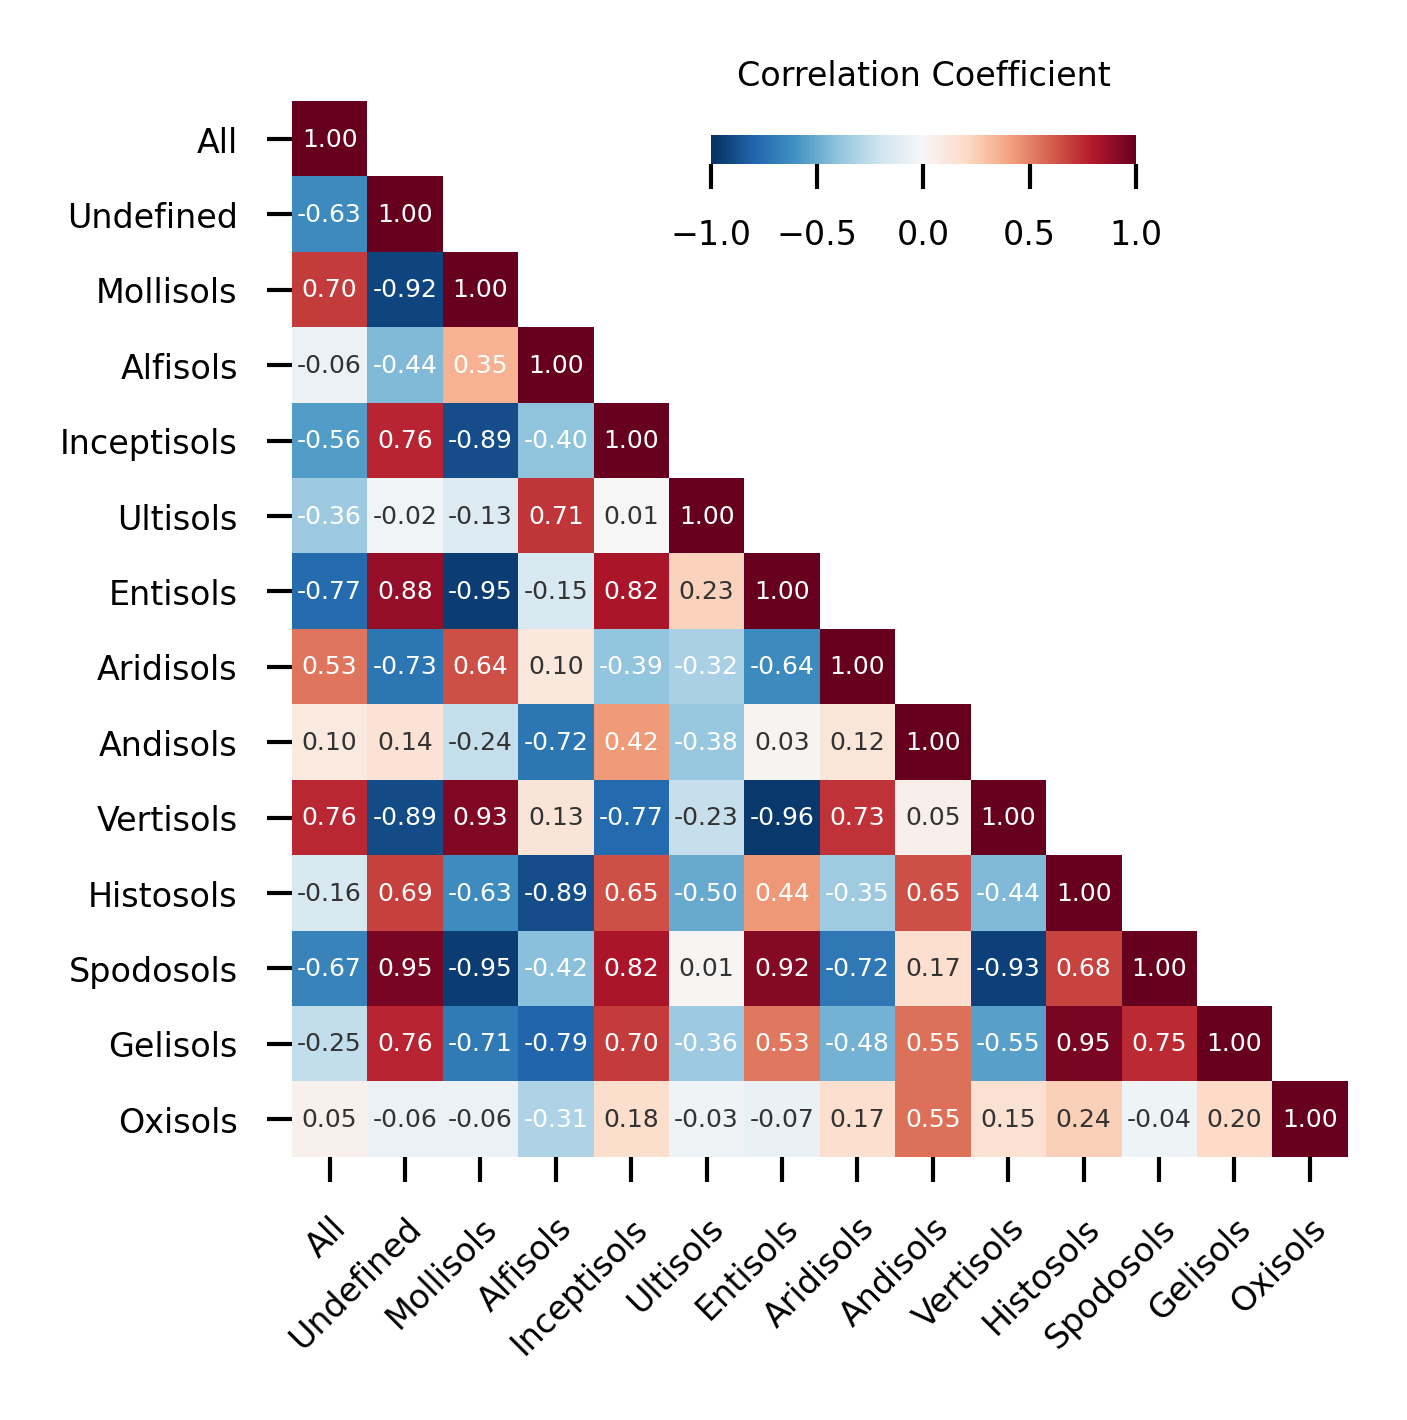

In [ ]:
#FIG_PATH = Path('nameofyourfolder')
FIG_PATH = Path('images/')
set_style(DEFAULT_STYLE)
plot_shaps_corr(shaps_corr, corr_labels)

# To save/export it
plt.savefig(FIG_PATH/'gradshap-order-corr.png', dpi=600, transparent=True, format='png')